In [2]:

import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import csv
import pandas as pd
import time
import datetime
import os
import urllib.request,urllib.parse
import zipfile
import win32api
import matplotlib.pyplot as mp
import seaborn as sns
mp.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mp.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
root_path=os.path.abspath('.')
test_data_path='test_data.json'
# test_data_path='E:\\0学习资料\\A软件工程\\数据科学大作业\\workspace\\test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateUserIds={}
getOldUserId=[]
for i in range(len(userIds)):
    updateUserIds.update({userIds[i]:i})
    getOldUserId.append(userIds[i])
del userIds
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
updateCaseIds={}
getOldCaseId=[]
for i in range(len(case_ids)):
    updateCaseIds.update({case_ids[i]:i})
    getOldCaseId.append(case_ids)
del case_ids
new_data=[]
for i in range(271):
    new_data.append(test_data[getOldUserId[i]]['cases'])
del test_data
for i in range(271):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_id']=updateCaseIds[new_data[i][j]['case_id']]
userFinishCaseIds=[]
for i in range(271):
    tempList=[]
    for j in range(len(new_data[i])):
        tempList.append(new_data[i][j]['case_id'])
    userFinishCaseIds.append(sorted(tempList))
caseIds200=[]
groupCaseIds=[]
ids882=[i for i in range(882)]
theFifthGroupCaseIds=set()
for i in range(271):
    ids='.'.join([str(i) for i in userFinishCaseIds[i]])
    if len(userFinishCaseIds[i])==200 and ids not in caseIds200:
        caseIds200.append(ids)
        groupCaseIds.append(userFinishCaseIds[i])
        for j in userFinishCaseIds[i]:
            ids882[j]=-1
for i in ids882:
    if i!=-1:
        theFifthGroupCaseIds.add(i)
fifthGroupIds=list(theFifthGroupCaseIds)
for i in range(271):
    if 190<=len(userFinishCaseIds[i])<=200:
        flag=False
        for j in theFifthGroupCaseIds:
            if j in userFinishCaseIds[i]:
                flag=True
                break
        if flag:
            for j in userFinishCaseIds[i]:
                fifthGroupIds.append(j)
groupCaseIds.append(sorted(list(set(fifthGroupIds))))
del fifthGroupIds
del theFifthGroupCaseIds
del ids882
del caseIds200
groupUserIds=[[] for i in range(5)]
ctGroupUserIds=[]
validUserIds=[]
for i in range(271):
    if len(userFinishCaseIds[i])>200:
        groupUserIds[4].append(i)
        continue
    if len(userFinishCaseIds[i])<=10:
        ctGroupUserIds.append(i)
        continue
    if i==261:
        groupUserIds[3].append(i)
        continue
    g=[]
    for j in range(5):
        flag=True
        for k in userFinishCaseIds[i]:
            if not k in groupCaseIds[j]:
                flag=False
                break
        if flag:
            g.append(j)
    if len(g)==1:
        groupUserIds[g[0]].append(i)
    else:
        ctGroupUserIds.append(i)
for i in groupUserIds:
    for j in i:
        validUserIds.append(j)
validUserIds=sorted(validUserIds)
groupUserNum=[len(i) for i in groupUserIds]
caseGroups=[[] for i in range(882)]
caseUserNum=[0 for i in range(882)]
caseUserNumInFact=[0 for i in range(882)]
caseScoreIgnoreUndo=[0 for i in range(882)]
caseScoreCountUndo=[0 for i in range(882)]
caseIdsByType=[set() for i in range(8)]
for i in range(882):
    for j in userFinishCaseIds:
        if i in j:
            caseUserNumInFact[i]+=1
    for j in range(len(groupCaseIds)):
        if i in groupCaseIds[j]:
            caseGroups[i].append(j)
            caseUserNum[i]+=groupUserNum[j]
caseFinishRate=list(np.array(caseUserNumInFact)/np.array(caseUserNum))
for i in range(len(new_data)):
    if i not in validUserIds:
        continue
    for j in range(len(new_data[i])):
        caseScoreIgnoreUndo[new_data[i][j]['case_id']]+=new_data[i][j]['final_score']
caseScoreCountUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNum))
caseScoreIgnoreUndo=list(np.array(caseScoreIgnoreUndo)/np.array(caseUserNumInFact))
for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        new_data[i][j]['case_type']=type_dict[new_data[i][j]['case_type']]
        caseIdsByType[new_data[i][j]['case_type']].add(new_data[i][j]['case_id'])
for i in range(len(caseIdsByType)):
    caseIdsByType[i]=sorted(list(caseIdsByType[i]))
def getGroupIdByUserId(userId):
    for i in range(len(groupUserIds)):
        if userId in groupUserIds[i]:
            return i
    return -1
def getGroupIdsByCaseId(caseId):
    gs=[]
    for i in range(len(groupCaseIds)):
        if caseId in groupCaseIds[i]:
            gs.append(i)
    return gs
def getTypesByCaseId(caseId):
    ts=[]
    for i in range(len(caseIdsByType)):
        if caseId in caseIdsByType[i]:
            ts.append(i)
    return ts
def getScoreByUserIdAndCaseId(userId,caseId):
    """
    返回某个用户在某道题上的得分,如果用户应该做这道题而没有做,则返回0分,如果这道题这个用户本来就不需要做(即用户所在的group内不包含这道题),就返回-1
    :param userId:
    :param caseId:
    :return:
    """
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['final_score']
    return 0
def getCaseIdsByGroupAndType(groupId,typeId):
    return sorted(list(set(caseIdsByType[typeId])&set(groupCaseIds[groupId])))
def getUploadNumByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -1
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return len(i['upload_records'])
    return 0
def getFinalUploadCodeUrlByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return ''
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['code_url']
    return ''
def getUploadSumByCaseId(caseId):
    r=0
    for i in validUserIds:
        r+=(getUploadNumByUserAndCase(i,caseId) if getUploadNumByUserAndCase(i,caseId)>0 else 0)
    return r
def getTimeSpanByUserAndCase(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return i['upload_records'][-1]['upload_time']-i['upload_records'][0]['upload_time']
    return -1
def getAvgTimeSpanByCase(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCase(i,caseId)>-1:
            r+=getTimeSpanByUserAndCase(i,caseId)
            n+=1
    return r/n
typeOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(8)]).transform([[i] for i in range(8)]).toarray()
groupOneHot=OneHotEncoder(categories='auto').fit([[i] for i in range(5)]).transform([[i] for i in range(5)]).toarray()
cases_analysis_result=np.array([])
def time_diff_minute(firstTime,secondTime):
    return (datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(secondTime/1000)),"%Y-%m-%d %H:%M:%S")-datetime.datetime.strptime(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(firstTime/1000)),"%Y-%m-%d %H:%M:%S")).total_seconds()/60
def getTimeSpanByUserAndCaseInMinute(userId,caseId):
    if not caseId in groupCaseIds[getGroupIdByUserId(userId)]:
        return -2
    for i in new_data[userId]:
        if i['case_id']==caseId:
            return time_diff_minute(i['upload_records'][0]['upload_time'],i['upload_records'][-1]['upload_time'])
    return -1
def getAvgTimeSpanByCaseInMinute(caseId):
    r=0
    n=0
    for i in validUserIds:
        if getTimeSpanByUserAndCaseInMinute(i,caseId)>-1:
            r+=getTimeSpanByUserAndCaseInMinute(i,caseId)
            n+=1
    return r/n
for i in range(882):
    typeId=np.zeros((8,))
    for j in getTypesByCaseId(i):
        typeId+=np.array(typeOneHot[j])
    finishRate=caseFinishRate[i]
    userNum=caseUserNum[i]
    userNumInFact=caseUserNumInFact[i]
    scoreIgnoreUndo=caseScoreIgnoreUndo[i]
    scoreCountUndo=caseScoreCountUndo[i]
    groupId=np.zeros((5,))
    for j in getGroupIdsByCaseId(i):
        groupId+=np.array(groupOneHot[j])
    uploadSum=getUploadSumByCaseId(i)
    uploadAvg=uploadSum/userNum
    uploadAvgInFact=uploadSum/userNumInFact
    timeSpan=getAvgTimeSpanByCaseInMinute(i)
    caseLine=np.concatenate((np.array([i]),typeId,np.array([finishRate]),np.array([userNum]),np.array([userNumInFact]),np.array([scoreIgnoreUndo]),np.array([scoreCountUndo]),groupId,np.array([uploadSum]),np.array([uploadAvg]),np.array([uploadAvgInFact]),np.array([timeSpan])),axis=0).reshape(1,-1)
    if i==0:
        cases_analysis_result=caseLine
    else:
        cases_analysis_result=np.concatenate((cases_analysis_result,caseLine),axis=0)
with open('cases_analysis_result.csv',mode='w',newline='') as file:
    cw=csv.writer(file)
    header=['id','type0','type1','type2','type3','type4','type5','type6','type7','finishRate','userNum','userNumInFact','scoreIgnoreUndo','scoreCountUndo','group0','group1','group2','group3','group4','uploadSum','uploadAvg','uploadAvgInFact','timeSpan']
    cw.writerow(header)
    for i in cases_analysis_result:
        cw.writerow(list(i))
"""
cases_analysis_result 数据说明:
shape:(882,23)
各列含义:
id:case_id 0~881
type0:如果这道题的类型是0类型,则此列为1,否则为0
type1~type7同上
finishRate:这道题的完成率 做了这道题的人数/应该做这道题的总人数
userNum:应该做这道题的总人数
userNumInFact:实际上做了这道题的人数
scoreIgnoreUndo:这道题的平均得分,忽略没做的人
scoreCountUndo:这道题的平均得分,如果应该做而没有做这道题的人,此题得分记为0
group0:如果这道题是第0组中的题目,则为1,否则为0
group1~group4同上
uploadSum:这道题的提交总次数
uploadAvg:平均每个人在这道题上的提交次数,如果有人应该做而没有做这道题,则提交次数记为0
uploadAvgInFact:平均每个人在这道题上的提交次数,忽略没有做这道题的人
timeSpan:做这道题的平均时间跨度,即最后一次提交时间减去第一次提交时间,单位是分钟
"""
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_result['timeSpan']=StandardScaler().fit_transform(np.array(cases_analysis_result['timeSpan']).reshape(-1,1))
cases_analysis_result['uploadSum']=StandardScaler().fit_transform(np.array(cases_analysis_result['uploadSum']).reshape(-1,1))
cases_analysis_result['scoreIgnoreUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreIgnoreUndo']).reshape(-1,1))
cases_analysis_result['scoreCountUndo']=StandardScaler().fit_transform(np.array(cases_analysis_result['scoreCountUndo']).reshape(-1,1))
cases_analysis_result['userNum']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNum']).reshape(-1,1))
cases_analysis_result['userNumInFact']=StandardScaler().fit_transform(np.array(cases_analysis_result['userNumInFact']).reshape(-1,1))
caseAllScores=[[] for i in range(882)]
for i in validUserIds:
    for j in range(len(new_data[i])):
        caseAllScores[new_data[i][j]['case_id']].append(new_data[i][j]['final_score'])
casesScoreVar=[np.var(np.array(caseAllScores[i])) for i in range(882)]
cases_analysis_result['scoreVar']=StandardScaler().fit_transform(np.array(casesScoreVar).reshape(-1,1))
def getCodeRunTime(code_url,userId,caseId):
    try:
        os.chdir('allcases')

        dirname=str(userId)+'_'+str(caseId)+'_dir'#存放原压缩包解压物的，每道题都有专属的文件夹名
        name=str(userId)+'_'+str(caseId)+'_zip'#原压缩包名

        urllib.request.urlretrieve(code_url,name)#下载原压缩包
        url_file=zipfile.ZipFile(name)#为原压缩包解压做准备

        os.mkdir(dirname)#原压缩包解压目录
        os.chdir(dirname)
        url_file.extractall()#原压缩包解压

        tmp=os.listdir(os.curdir)#当前目录为原压缩包解压目录，即获取原压缩包解压出来的压缩包名
        temp=tmp[0]#第二个压缩包名
        tempp=zipfile.ZipFile(temp)
        tempp.extractall()
        #第二个压缩包在此解压

        tmp=os.listdir(os.curdir)#再次获取当前目录内的所有文件名，以获得py文件进行运行
        code_name=''
        for i in tmp:
            if i[-3::]=='.py':
                code_name=i#py文件名

        start_time=time.clock()
        win32api.ShellExecute(0,'open',code_name,'','',0)
        end_time=time.clock()

        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录

        return end_time-start_time
    except:
        os.chdir('..')#返回至allcases目录
        os.chdir('..')#返回主目录
        return -1
def getUserIdsByCaseId(caseId):
    r=[]
    for i in validUserIds:
        if caseId in userFinishCaseIds[i]:
            r.append(i)
    return r
# def getCodeRunTime(code_url,userId,caseId):
#     return random.uniform(0,1)
codeRunTime=-np.ones((271,882))
# 下载所有代码并计算运行时间
# for i in validUserIds:
#     for j in range(882):
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# 抽样下载代码并计算运行时间
# for j in range(882):
#     for i in [random.choice(getUserIdsByCaseId(j))]:
#         if getFinalUploadCodeUrlByUserAndCase(i,j)!='':
#             codeRunTime[i,j]=getCodeRunTime(getFinalUploadCodeUrlByUserAndCase(i,j),i,j)
#             os.chdir(root_path)
# with open('code_run_time.csv',mode='w',newline='') as file:
#     cw=csv.writer(file)
#     for i in codeRunTime:
#         cw.writerow(list(i))
codeRunTime=pd.read_csv('code_run_time.csv',header=None).values
def getCaseAvgRunTime(caseId):
    sumTime=0
    for i in validUserIds:
        if codeRunTime[i,caseId]>-1:
            sumTime+=codeRunTime[i,caseId]
    return sumTime/caseUserNumInFact[caseId]
cases_analysis_result['avgRunTime']=StandardScaler().fit_transform(np.array([getCaseAvgRunTime(i) for i in range(882)]).reshape(-1,1))
def difficult_degree(caseId):

    return -cases_analysis_result.iloc[caseId]['finishRate']-cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result.iloc[caseId]['scoreCountUndo']+cases_analysis_result.iloc[caseId]['uploadAvg']+cases_analysis_result.iloc[caseId]['uploadAvgInFact']+cases_analysis_result.iloc[caseId]['timeSpan']+cases_analysis_result.iloc[caseId]['avgRunTime']
cases_analysis_result['difficultDegree']=np.array([difficult_degree(i) for i in range(882)]).reshape(-1,1)
cases_analysis_result.to_csv('cases_analysis_final.csv')
cases_result_array=cases_analysis_result.values
def getTypeDifficultDegree(typeId):
    d=0
    for caseId in caseIdsByType[typeId]:
        d+=difficult_degree(caseId)
    return d/len(caseIdsByType[typeId])
def getGroupDifficultDegree(groupId):
    d=0
    for caseId in groupCaseIds[groupId]:
        d+=difficult_degree(caseId)
    return d/len(groupCaseIds[groupId])
def getTypeAvgScoreIgnoreUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreIgnoreUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreIgnoreUndo']
    return s/len(groupCaseIds[groupId])
def getTypeAvgScoreCountUndo(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(caseIdsByType[typeId])
def getGroupAvgScoreCountUndo(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['scoreCountUndo']
    return s/len(groupCaseIds[groupId])
def test_cases_oriented(path):
    f=open(path,'r',encoding='utf-8')
    #以下为测行数、print数
    count=1  #行数
    pcount=0 #print数
    ifcount=0 # if elif else数
    line=f.readline()
    line=line[:-1]
    while line:
        if line.count("print")>0:
            pcount+=1
        if line.count("if")>0 or line.count("elif") or line.count("else")>0:
            ifcount+=1
        line=line.strip()  #去掉前后空格
        if line: #不为空行
            if not line[0]=="#": #不为注释行
                count+=1
        line=f.readline()
    #以下为检测
    return pcount>5 or (pcount/count)>0.3 or count<5 or ifcount>5 or ifcount/count>0.3
def getGroupAvgFinishRate(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=caseFinishRate[caseId]
    return s/len(groupCaseIds[groupId])
def getTypeAvgFinishRate(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=caseFinishRate[caseId]
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNum(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNum(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvg']
    return s/len(caseIdsByType[typeId])
def getGroupAvgUploadNumInFact(groupId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(groupCaseIds[groupId])
def getTypeAvgUploadNumInFact(typeId):
    temp=pd.read_csv('cases_analysis_result.csv')
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=temp.iloc[caseId]['uploadAvgInFact']
    return s/len(caseIdsByType[typeId])
def getGroupAvgTimeSpanInMinute(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(groupCaseIds[groupId])
def getTypeAvgTimeSpanInMinute(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getAvgTimeSpanByCaseInMinute(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfCase(caseId):
    return 30+cases_analysis_result.iloc[caseId]['finishRate']-abs(cases_analysis_result.iloc[caseId]['scoreIgnoreUndo']-cases_analysis_result['scoreIgnoreUndo'].mean())+cases_analysis_result.iloc[caseId]['scoreVar']-abs(cases_analysis_result.iloc[caseId]['difficultDegree']-cases_analysis_result['difficultDegree'].mean())-abs(cases_analysis_result.iloc[caseId]['uploadAvgInFact']-3)
def getGoodnessOfType(typeId):
    s=0
    for caseId in caseIdsByType[typeId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(caseIdsByType[typeId])
def getGoodnessOfGroup(groupId):
    s=0
    for caseId in groupCaseIds[groupId]:
        s+=getGoodnessOfCase(caseId)
    return s/len(groupCaseIds[groupId])


In [3]:
cases_analysis_result=pd.read_csv('cases_analysis_result.csv')
cases_analysis_final=pd.read_csv('cases_analysis_final.csv').iloc[:,1:]
cases_pca_2_dim=pd.read_csv('cases_pca_2_dim_result.csv')
cases_pca_4_dim=pd.read_csv('cases_pca_4_dim_result.csv')
cases_ae_2_dim=pd.read_csv('cases_ae_encode_2_dim.csv')
cases_ae_4_dim=pd.read_csv('cases_ae_encode_4_dim.csv')
cases_vae_2_dim=pd.read_csv('cases_vae_encode_2_dim.csv')
cases_vae_4_dim=pd.read_csv('cases_vae_encode_4_dim.csv')

In [147]:
type_dict={'排序算法':0,'查找算法':1,'图结构':2,'树结构':3,'数字操作':4,'字符串':5,'线性表':6,'数组':7}
test_data_path='test_data.json'
test_data=json.loads(open(test_data_path,encoding='utf-8').read())
userIds=[str(i) for i in sorted([int(i) for i in list(test_data.keys())])]
updateIds={}
train_data=[]
for i in range(len(userIds)):
    updateIds.update({userIds[i]:i})
case_ids=set()
for i in test_data:
    for j in test_data[i]['cases']:
        case_ids.add(j['case_id'])
case_ids=sorted(list(case_ids))
caseIds={}
for i in range(len(case_ids)):
    caseIds.update({case_ids[i]:i})
for i in userIds:
    test_data[i]['user_id']=updateIds[i]
    for j in range(len(test_data[i]['cases'])):
        test_data[i]['cases'][j]['case_type']=type_dict[test_data[i]['cases'][j]['case_type']]
        test_data[i]['cases'][j]['case_id']=caseIds[test_data[i]['cases'][j]['case_id']]
    train_data.append(test_data[i]['cases'])
userFinishAll=[]
for i in range(len(train_data)):
    if len(train_data[i])==200:
        tempCaseIds=[]
        for j in range(len(train_data[i])):
            tempCaseIds.append(train_data[i][j]['case_id'])
        userFinishAll.append(sorted(tempCaseIds))
fiveGroupsCaseIds=[userFinishAll[0]]
for i in range(len(userFinishAll)):
    shouldAdd=True
    for j in range(len(fiveGroupsCaseIds)):
        if userFinishAll[i]==fiveGroupsCaseIds[j]:
            shouldAdd=False
            break
    if shouldAdd:
        fiveGroupsCaseIds.append(userFinishAll[i]) # 为啥只有四组,我感觉怪怪的
getTypeScoreByStuId=np.zeros((271,8),dtype=np.float) # 记录每个学生在每类题目上的得分,没有做的题目会被忽略,即不会被计入
numByType=np.zeros((271,8),dtype=np.int) # 中间变量 可以忽略
getAvgScoreByCaseId=np.zeros((882,1),np.float) # 记录每道题的平均得分,未做的题目会被忽略
getCaseTypeByCaseId=np.zeros((882,1),dtype=np.int)
getCaseIdsByCaseType=[set() for i in range(8)]
getScoresByCaseId=[[] for i in range(882)]
getCaseIdsByStuId=[[[] for j in range(8)] for i in range(271)] # 记录每个学生做了的题目的id
getNumOfUpload=np.zeros((271,882),dtype=np.int)
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        getCaseTypeByCaseId[train_data[i][j]['case_id'],0]=train_data[i][j]['case_type']
caseIdsWithMoreTypes=[]
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        if train_data[i][j]['case_type']!=getCaseTypeByCaseId[train_data[i][j]['case_id'],0]:
            caseIdsWithMoreTypes.append(str(train_data[i][j]['case_id'])+'_'+str(train_data[i][j]['case_type']))
            train_data[i][j]['case_type']=getCaseTypeByCaseId[train_data[i][j]['case_id'],0] # 限定每道题只能有一种类型
        getNumOfUpload[i,train_data[i][j]['case_id']]=len(train_data[i][j]['upload_records'])
        getTypeScoreByStuId[i,train_data[i][j]['case_type']]+=train_data[i][j]['final_score']
        numByType[i,train_data[i][j]['case_type']]+=1
        getAvgScoreByCaseId[train_data[i][j]['case_id'],0]+=train_data[i][j]['final_score']
        # getCaseTypeByCaseId[train_data[i][j]['case_id'],0]=train_data[i][j]['case_type']
        getCaseIdsByCaseType[train_data[i][j]['case_type']].add(train_data[i][j]['case_id'])
        getScoresByCaseId[train_data[i][j]['case_id']].append(train_data[i][j]['final_score'])
        getCaseIdsByStuId[i][train_data[i][j]['case_type']].append(train_data[i][j]['case_id'])
caseIdsWithMoreTypes=list(set(caseIdsWithMoreTypes))
for i in range(len(getCaseIdsByCaseType)):
    getCaseIdsByCaseType[i]=sorted(list(getCaseIdsByCaseType[i]))

getAllCaseIdsByStuId=[[] for i in range(271)]
for i in range(len(getAllCaseIdsByStuId)):
    for j in range(len(getCaseIdsByStuId[i])):
        getAllCaseIdsByStuId[i]+=getCaseIdsByStuId[i][j]

# 如果要把没做的题目当作0分,就把下式的np.array([len(i) for i in getScoresByCaseId]).reshape(-1,1)改成271
getAvgScoreByCaseId/=np.array([len(i) for i in getScoresByCaseId]).reshape(-1,1)
# getAvgScoreByCaseId/=271
for i in range(len(getTypeScoreByStuId)):
    for j in range(len(getTypeScoreByStuId[i])):
        if numByType[i,j]!=0:
            getTypeScoreByStuId[i,j]/=numByType[i,j]
getSumOfUpload=np.sum(getNumOfUpload,axis=1).reshape(-1,1)
getAvgScoreByType=np.zeros((8,1),dtype=np.float)
getNumOfCaseByType=np.zeros((8,1),dtype=np.int)
for i in range(882):
    getAvgScoreByType[getCaseTypeByCaseId[i]]+=getAvgScoreByCaseId[i]
    getNumOfCaseByType[int(getCaseTypeByCaseId[i])]+=1
getAvgScoreByType/=getNumOfCaseByType
uploadSum=[getUploadSumByCaseId(x) for x in range(882)]
spanTime=[getAvgTimeSpanByCaseInMinute(x) for x in range(882)]
difficulty=[difficult_degree(x) for x in range(882)]
fr=[caseUserNum[x]/caseUserNumInFact[x] for x in range(882)]
runtime=[getCaseAvgRunTime(x) for x in range(882)]

In [4]:
typetimeSpan=[getTypeAvgTimeSpanInMinute(x)/15 for x in range(8)]
groupTimeSpan=[getGroupAvgTimeSpanInMinute(x)/15 for x in range(5)]
typeAverageScoreCount=[getTypeAvgScoreCountUndo(x) for x in range(8)]
groupAverageScoreCount=[getGroupAvgScoreCountUndo(x) for x in range(5)]
typeAverageScoreIg=[getTypeAvgScoreIgnoreUndo(x) for x in range(8)]
groupAverageScoreIg=[getGroupAvgScoreIgnoreUndo(x) for x in range(5)]
typeFR=[getTypeAvgFinishRate(x)*100 for x in range(8)]
groupFR=[getGroupAvgFinishRate(x)*100 for x in range(5)]
typeUploadNum=[getTypeAvgUploadNum(x)*50 for x in range(8)]
groupUploadNum=[getGroupAvgUploadNum(x)*50 for x in  range(5)]
typeDifficulty=[getTypeDifficultDegree(x)*15 for x in range(8)]
groupDifficulty=[getGroupDifficultDegree(x)*15 for x in range(5)]
typequality=[getGoodnessOfType(x) for x in range(8)]
groupquality=[getGoodnessOfGroup(x) for x in range(5)]
typeRadar=pd.DataFrame(
    [[typeAverageScoreIg[x],typeAverageScoreCount[x],typeFR[x],typeDifficulty[x],typetimeSpan[x],typeUploadNum[x]] for x in range(8)]
    ,columns=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数'])
groupRadar=pd.DataFrame(
    [[typeAverageScoreIg[x],typeAverageScoreCount[x],typeFR[x],typeDifficulty[x],typetimeSpan[x],typeUploadNum[x]] for x in range(5)]
    ,columns=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数'])


KeyError: 'avgRunTime'

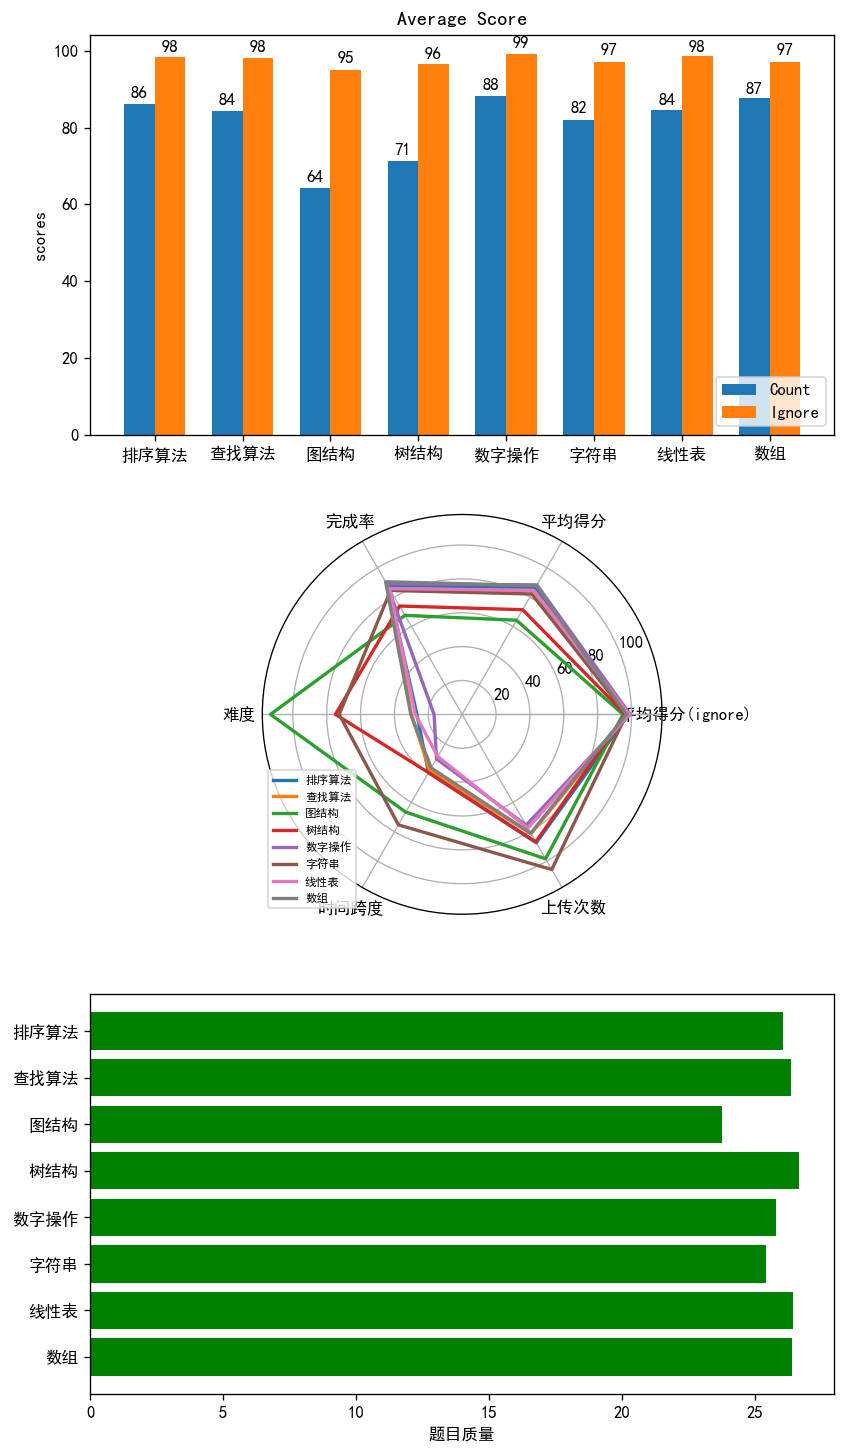

In [93]:
def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def getTypeView():
    labels=type_dict.keys()
    x = np.arange(len(labels))
    width=0.35
    mp.figure(figsize=(8,15), dpi=120)
    mp.figure(1)
    #分组条形
    ax1=mp.subplot(311)
    ax1.set_title("Average Score")
    ax1.set_ylabel('scores')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels)
    rect1=ax1.bar(x-width/2,typeAverageScoreCount,width,label='Count')
    rect2=ax1.bar(x+width/2,typeAverageScoreIg,width,label='Ignore')
    ax1.legend([rect1,rect2],['Count','Ignore'],loc='lower right')
    autolabel(rect1,ax1)
    autolabel(rect2,ax1)
    #雷达图
    ax2=mp.subplot(312, polar=True)
    labels=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数']
    kinds=list(type_dict.keys())
    global typeRadar
    result=pd.concat([typeRadar,typeRadar['平均得分(ignore)']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax2.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax2.set_thetagrids(angle*180/np.pi,labels)
    ax2.legend(loc='lower left',fontsize='x-small')
    #题目质量水平条形图
    global typequality
    ax3=mp.subplot(313)
    ax3.barh(np.arange(8),typequality,color='g')
    ax3.set_yticks(np.arange(8))
    ax3.set_yticklabels(kinds)
    ax3.invert_yaxis()
    ax3.set_xlabel('题目质量')
    mp.show()
getTypeView()

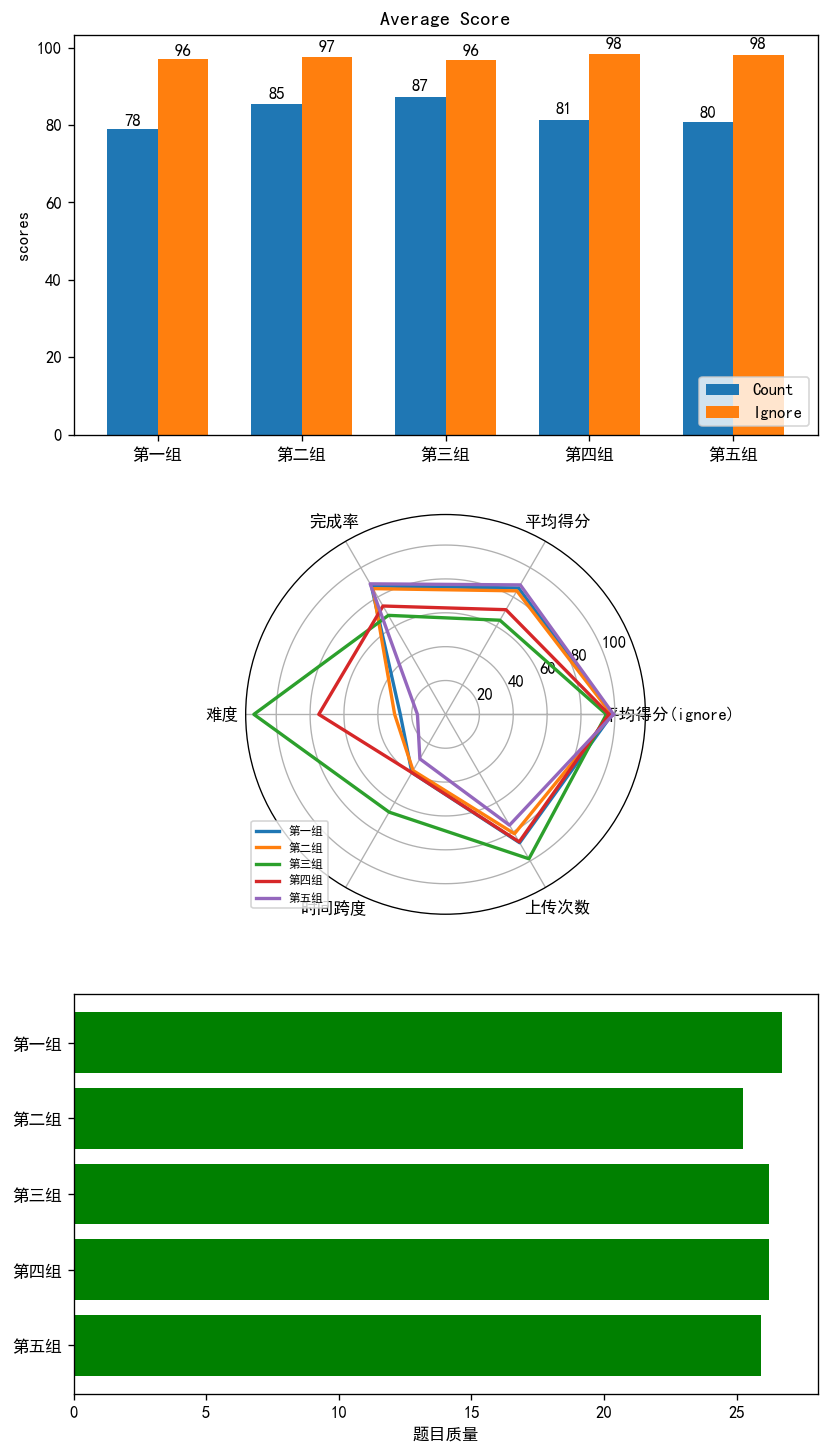

In [131]:
def getGroupView():
    labels=['第一组','第二组','第三组','第四组','第五组']
    x = np.arange(len(labels))
    width=0.35
    mp.figure(figsize=(8,15), dpi=120)
    mp.figure(1)
    #分组条形
    ax1=mp.subplot(311)
    ax1.set_title("Average Score")
    ax1.set_ylabel('scores')
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels)
    rect1=ax1.bar(x-width/2,groupAverageScoreCount,width,label='Count')
    rect2=ax1.bar(x+width/2,groupAverageScoreIg,width,label='Ignore')
    ax1.legend([rect1,rect2],['Count','Ignore'],loc='lower right')
    autolabel(rect1,ax1)
    autolabel(rect2,ax1)
    #雷达图
    ax2=mp.subplot(312, polar=True)
    kinds=labels
    labels=['平均得分(ignore)','平均得分','完成率','难度','时间跨度','上传次数']
    global groupRadar
    result=pd.concat([groupRadar,groupRadar['平均得分(ignore)']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax2.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax2.set_thetagrids(angle*180/np.pi,labels)
    ax2.legend(loc='lower left',fontsize='x-small')
    #题目质量水平条形图
    global groupquality
    ax3=mp.subplot(313)
    ax3.barh(np.arange(5),groupquality,color='g')
    ax3.set_yticks(np.arange(5))
    ax3.set_yticklabels(kinds)
    ax3.invert_yaxis()
    ax3.set_xlabel('题目质量')
    mp.show()
getGroupView()


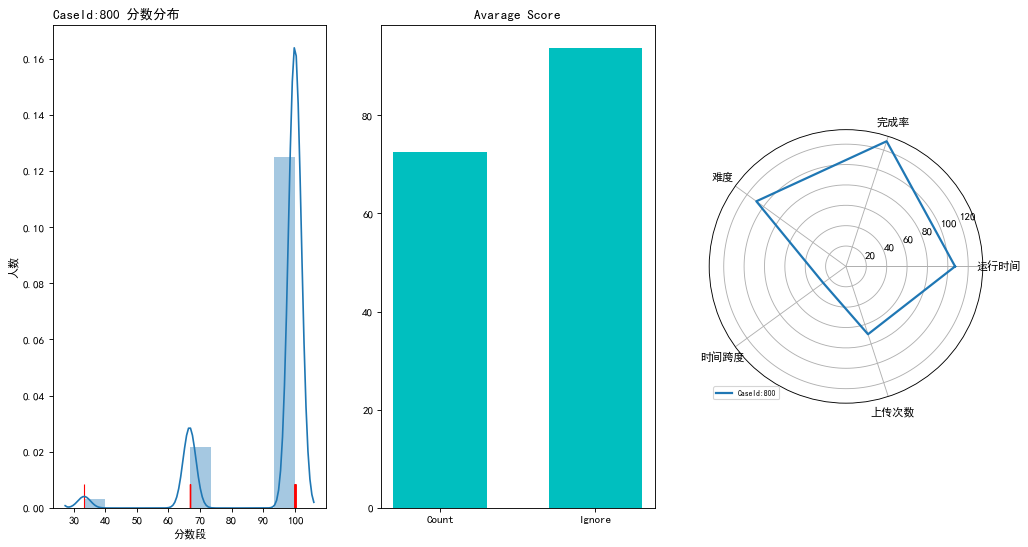

In [155]:
def getViewByCaseId(x):
    mp.figure(figsize=(15,8), dpi=80)
    mp.figure(1)
    #
    ax1=mp.subplot(131)
    label='CaseId:'+str(x)+' 分数分布'
    caseScore=pd.DataFrame(np.array(caseAllScores[x]).reshape(1,-1))
    bins = np.arange(0, 101, 10)
    ax1.set_title(label,loc='left')
    ax1.set_xticks(range(0,101,10))
    ax1.set_xlabel('分数段')
    ax1.set_ylabel('人数')
    sns.distplot(caseScore,bins=10,ax=ax1,rug=True,rug_kws = {'color' : 'r'},
            kde_kws = {'bw' : 2})
    #
    ax2=mp.subplot(132)
    group=["Count","Ignore"]
    mean=np.array([caseScoreCountUndo[x],caseScoreIgnoreUndo[x]])
    ax2.set_title('Avarage Score')
    mp.bar(group,mean,color='c',width=0.6,align='center')
    #雷达图
    ax3=mp.subplot(133, polar=True)
    labels=['运行时间','完成率','难度','时间跨度','上传次数']
    kinds=['CaseId:'+str(x)]
    CR=pd.DataFrame([[runtime[x]*100000,fr[x]*100,difficulty[x]*30,spanTime[x]/5,uploadSum[x]]]
    ,columns=['运行时间','完成率','难度','时间跨度','上传次数'])
    result=pd.concat([CR,CR['运行时间']],axis=1)
    centers=np.array(result.iloc[:,:])
    n=len(labels)
    angle=np.linspace(0,2*np.pi,n,endpoint=False)
    angle=np.concatenate((angle,[angle[0]]))
    pic=[]
    for i in range(len(kinds)):
        pic.append(ax3.plot(angle,centers[i],linewidth=2,label=kinds[i]))
    ax3.set_thetagrids(angle*180/np.pi,labels)
    ax3.legend(loc='lower left')
    mp.show()
getViewByCaseId(800)